# fig_grpPopHFA_relateToGroups


### This notebook generates figures relates population dynamics results to specific groups of electrodes. It focuses on across subject correlations between dynamics and model parameters. Uses a leave-one-out approach to measure how removing a specific electrode group  impacts the correlation between neural dynamics and model parameters. Can extend to pairwise interactions between clusters or groups of clusters by removing more than one group at a time. Main intention is to study the effect of removing clusters, but can also study removing brain regions. 


In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
#FDR correction
from statsmodels.stats.multitest import multipletests as FDR
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 14
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/fig_grpPopHFA_importantGroups/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
    #plt.savefig(fname = fig_dir+fname+'.png')


# Collect Group taskstats Data, filter and cluster
C = cc.Collection(collection_lbl='all')

C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])



# filter to only include good electrodes and specific regions
goodElecsIdx = np.array(C.isBadElectrode_list)==False

# option to only filter good electrodes
C.filterElectrodes(filtE_bool= goodElecsIdx)

#option to filter to include specific brain regions and only good electrodes
anatDf2,roiList2 = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='yeo');
retIdx = (anatDf2['roi']=='Visual') | \
(anatDf2['roi']=='Limbic') | \
(anatDf2['roi']=='Salience') | \
(anatDf2['roi']=='Somatomotor') 
#C.filterElectrodes(filtE_bool=retIdx&goodElecsIdx)

# get anatDf
atlas='default'
#atlas='yeo'
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas=atlas);

# cluster based on features
feat_option = 'selectivity'
cut_level=21
#cut_level=28

#feat_option = 'selectivity_rtOnly'
#cut_level=12

#feat_option = 'selectivity_delayOnly'
#cut_level=14

#feat_option = 'selectivity_anat'
#cut_level=19

C.clusterElectrodesByTaskStats(feat_option=feat_option,binarize_stats=True,atlas=atlas)

# criteria for including clusters
min_subj = 5
#min_elecs = 25
min_elecs = 50


# option to toggle pairwise comparisons
include_pairwise_comparisons = False

# set resid_str and neu_feat_list for delay-related comparisons
resid_str = ''
neu_feat_list = ['SR_distMean','SR_speedMean','SR_headingCorrectMean','S0reg','S0var','Streg','Stvar']


In [2]:
# subfunctions to plot and return correlation values
def get_xSubj_corrPercentageChange(C,sc_df,sc_df_all,beh_var_lbl,neu_feat,s_idx = None):
    # This function computes percentage change in across-subject correlation coefficient per electrode
    # C is collection object
    # sc_df - sc_df associated obtained by removing this specific electrode group
    # sc_df_all - sc_df associated with measurement across all electrodes
    # beh_var_lbl - across subject behavioral difference (e.g., errorDiff, or rtDiff_mean)
    # neu_feat - neural feature to focus on e.g., 'sr_headingCorrectMean'
    # s_idx - boolean of subjects if you only want to focus on a subgroup of subjects
    
    # parse subj idx (to perform analysis only for a subgroup o fsubjects)
    if s_idx is None:
        s_idx = np.ones(len(sc_df)).astype('bool')


    # decrease in number of electrodes 
    change_in_n = np.sum(sc_df_all['n_obs'].to_numpy()) - np.sum(sc_df['n_obs'].to_numpy()) 
    # decrease in number of electrodes 
    change_in_s = len(np.unique(sc_df_all['subj'].to_numpy())) - len(np.unique(sc_df['subj'].to_numpy()))    
    # change in correlation coefficient
    # set labels
    resid_str = ''
    n_lbl = 'popByDelay'+resid_str+'_'+neu_feat+'_diff'
    
    # get r value using all electrodes
    r_value_all,p_value_all = stats.spearmanr(sc_df_all[beh_var_lbl][s_idx],sc_df_all[n_lbl][s_idx])
   
    # get r value using subgroup electrodes
    r_value,p_value = stats.spearmanr(sc_df[beh_var_lbl][s_idx],sc_df[n_lbl][s_idx])
    
    
    # compute percentage change (negative sign here means that 
    # negative values indicate that effect got weaker and positive values
    #indicate that effect got stronger got stronger)
    corr_prct_change = -100*(np.abs(r_value_all) - np.abs(r_value))/(np.abs(r_value_all))

    
    # relative importance score (> 1 indicates more importance because
    # effect got weaker withouth this group)
    rel_imp_score = np.abs(r_value_all)/np.abs(r_value)

    # Note: correcting theses measures by dividing by change in n doesnt do a good job as it overcorrects. see "adjust_corr_dict" below
    #corr_prct_change_perElectrode = np.copy(corr_prct_change)/change_in_n
    #rel_imp_score_per_electrode = np.copy(rel_imp_score)/change_in_n

    #save data in containers
    corr_dict = {}    
    corr_dict['change_in_n'] = change_in_n
    corr_dict['r_value_all'] = r_value_all
    corr_dict['r_value'] = r_value
    corr_dict['corr_prct_change'] = corr_prct_change
    corr_dict['rel_imp_score'] = rel_imp_score

    #corr_dict['corr_prct_change_perElectrode'] = corr_prct_change_perElectrode    
    #corr_dict['rel_imp_score_perElectrode'] = rel_imp_score_per_electrode    
    return corr_dict



# get null distribution
# this subfunction gets a null distribution for relative importance score for 
# a particular across-subject correlation 
def get_null_distribution(sc_df_dict_null,sc_df_all,beh_var_lbl='rtDiff_mean',\
                               neu_feat='SR_headingCorrectMean'):
    null_lbl_list = list(sc_df_dict_null.keys())
    null_corr_dict_list = []
    for null_lbl in null_lbl_list:
        null_corr_dict = get_xSubj_corrPercentageChange(C,sc_df_dict_null[null_lbl],sc_df_all,beh_var_lbl=beh_var_lbl,neu_feat=neu_feat)
        null_corr_dict_list.append(null_corr_dict)

    null_df_byGroup = pd.DataFrame(null_corr_dict_list,index = null_lbl_list)
    
    return null_df_byGroup    


def adjust_corrDf(corr_df_byGroup,null_df_byGroup):
    """ This function corrects a each electrode group's relative importance score  (or corr_prct_change) by the number of electrodes en each group. 
    It estimates the effect of number of electrodes on magnitude of relative importance score via a linear model and adjusts values accordingly. 
    Only implemented for rel_imp_score."""
    
    # dependent var - magnitude of rel imp score as absolute deviation from 1 (no effect of removing group)
    y = np.absolute(corr_df_byGroup['rel_imp_score'].to_numpy()-1)
    
    #indep var is size of elec group
    x = np.copy(corr_df_byGroup['change_in_n'].to_numpy())
    
    # compute linear model 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    # calculate adjusted relative importance score separately 
    # for positive and negative deviations from 1. Here we are 
    # bringing each value closer to 1 based on the predicted effect
    # size from the linear model. but don't over-correct past 1
    rel_imp_score = corr_df_byGroup['rel_imp_score'].to_numpy()
    rel_imp_score_adj = np.ones(np.shape(rel_imp_score))
    
    for i in range(0,len(rel_imp_score_adj)):
        
        # calculate correction value based on number of electrodes in this group (y_pred)
    
        y_pred = (x[i]*slope) + intercept
        
        if rel_imp_score[i]> 1:
            #rel_imp_score_adj[i] = np.max((rel_imp_score[i]-y_pred,1))
            rel_imp_score_adj[i] = rel_imp_score[i]-y_pred
        elif rel_imp_score[i] < 1:
            #rel_imp_score_adj[i] = np.min((rel_imp_score[i]+y_pred,1))
            rel_imp_score_adj[i] = rel_imp_score[i]+y_pred

        elif rel_imp_score[i]== 1:
            # if rel imp score is 1, leave it alone because we dont know the direction of effect
            rel_imp_score_adj[i] = 1
            
    # compute z-scored rel_imp_score_adj so we can calculate relative importance of an electrode group
    # relative to other gorups
    
    rel_imp_score_adj_z = stats.zscore(rel_imp_score_adj)
    
    
    # add columns to dataframe
    corr_df_byGroup.insert(loc = len(corr_df_byGroup.columns),column='rel_imp_score_adj',value=rel_imp_score_adj)
    corr_df_byGroup.insert(loc = len(corr_df_byGroup.columns),column='rel_imp_score_adj_z',value=rel_imp_score_adj_z)
    # 
    return corr_df_byGroup
    


# get non-param p-values and z-stats (compares corr_dict to null_df)
def get_p_two_tailed(null_vals,true_val):

    # parse true_val
    # we are using median null value here in case the null distribution is not symmetric about zero
    if true_val>=np.median(null_vals): #0
        # probability of observing a null value greater than true value
        pval_np = np.count_nonzero(null_vals >= true_val)/len(null_vals)
    else:
        # prob of observing a null value less than true value
        pval_np = np.count_nonzero(null_vals <= true_val)/len(null_vals)
    # multiply by 2 to make it a two-tailed p-value (ceiling value = 1)
    pval_np = np.min((1,pval_np * 2))

    #zscore of the effect
    zstat_np = (true_val - np.mean(null_vals))/np.std(null_vals)

    return pval_np,zstat_np

def fdr_wrapper(p_list,lbls_list):
    # make sure there are no nans
    p_list = np.array(p_list)
    p_list[np.isnan(p_list)]=1
    reject,pvals_corrected,AS,AB =  FDR(pvals = p_list, alpha = 0.05,method = 'fdr_bh')

    print('\n')
    print('FDR-corrected p values')
    print(np.hstack((np.array(lbls_list).squeeze()[:,np.newaxis],\
                     np.array(np.round(pvals_corrected,3)).squeeze()[:,np.newaxis])))
    
    return pvals_corrected

In [4]:
##### CODE BLOCK TO run an sc_df withouth specific electrode groups


# # ####
# # leave one out clusters
# cut_level = 21
# clus_list = C.clus_getEligibleClusters(cut_level=cut_level,min_subj_thresh=5,min_elec_thresh=50)
# # loop through cluster list and run sc_df without that cluster
# for i in clus_list:
#     # get electrode masks without this cluster
#     ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = cut_level, clus_id_list=[i], exclude_flag = True)

#     # load it 
#     sc_df_dict['without-'+str(i)] = C.getSubjCollectionDf(filter_bool =ret_idx,filter_bool_lbl =ret_str,popStats_iters = 1)


# # ####
# # leave one out region
# # loop through roi list and run sc_df without that cluster
# for r in roiList:
#     # get electrode masks without this cluster
#     ret_idx = (anatDf.eval('roi==@r'))==False
    
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)
#     if '/' in r:
#         ret_lbl = r.split('/')[0]
#     else:
#         ret_lbl = r
#     # run it 
#     sc_df_dict['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
#                                                            filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)




# # # leave one out RT or delay relation    
# sc_df_dict_func = {}
# p_thresh=0.05
# beh_feat='zrrtStoch'
# n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
# ret_idx_delay_any = np.zeros(len(C.taskstats2d_df)).astype('bool')
# ret_idx_rt_any = np.zeros(len(C.taskstats2d_df)).astype('bool')

# for n in n_feat_list:

#     # update bools
#     if n != 'S0f':    
#         ret_idx_delay_any =  ret_idx_delay_any|(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)

#         # run without delay pos
#         ret_idx = (C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()>0)&(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)
#         ret_idx = C.retIdx2masterRetIdx(ret_idx)
#         ret_lbl = 'delayElectrodes'+n+'-pos'
#         sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
#                                                            filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)
    
#         # run without delay neg
#         ret_idx = (C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()<0)&(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)
#         ret_idx = C.retIdx2masterRetIdx(ret_idx)
#         ret_lbl = 'delayElectrodes'+n+'-neg'
#         sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
#                                                            filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)
#     ret_idx_rt_any = ret_idx_rt_any|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)

#     # run without rt pos
#     ret_idx = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_zstatnp'].to_numpy()>0)|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)
#     ret_lbl = 'rtElectrodes'+n+'-pos'
#     sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
#                                                            filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)
#     # run without rt neg
#     ret_idx = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_zstatnp'].to_numpy()<0)|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)
#     ret_lbl = 'rtElectrodes'+n+'-neg'
#     sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
#                                                            filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)
    

# # convert to master ret_idx
# ret_idx_delay_any = C.retIdx2masterRetIdx(ret_idx_delay_any)
# ret_idx_rt_any = C.retIdx2masterRetIdx(ret_idx_rt_any)


# # run them
# ret_lbl = 'delayElectrodes'
# sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =(ret_idx_rt_any==False),filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)
    
# ret_lbl = 'rtElectrodes'    
# sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =(ret_idx_rt_any==False),filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)

# ret_lbl = 'delayAndRtElectrodes'
# sc_df_dict_func['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =(ret_idx_rt_any==False),filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)



### OLD
# ## without electrodes showing specific RT and delay-related differences

# p_thresh=0.05
# beh_feat='zrrtStoch'
# #n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
# n_feat_list = ['preResponse']
# ret_idx_delay_any = np.zeros(len(C.taskstats2d_df)).astype('bool')
# ret_idx_rt_any = np.zeros(len(C.taskstats2d_df)).astype('bool')

# for n in n_feat_list:

#     # update bools
#     if n != 'S0f':    
#         ret_idx_delay_any =  ret_idx_delay_any|(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)

#         # run without delay pos
#         ret_idx = (C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()>0)&(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)
#         ret_idx = C.retIdx2masterRetIdx(ret_idx)
#         C.getSubjCollectionDf(filter_bool =(ret_idx==False),filter_bool_lbl ='without-delayElectrodes'+n+'-pos',popStats_iters = 1)

#         # run without delay neg
#         ret_idx = (C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()<0)&(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)
#         ret_idx = C.retIdx2masterRetIdx(ret_idx)
#         C.getSubjCollectionDf(filter_bool =(ret_idx==False),filter_bool_lbl ='without-delayElectrodes'+n+'-neg',popStats_iters = 1)

#     ret_idx_rt_any = ret_idx_rt_any|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)

#     # run without rt pos
#     ret_idx = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_zstatnp'].to_numpy()>0)|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)
#     C.getSubjCollectionDf(filter_bool =(ret_idx==False),filter_bool_lbl ='without-rtElectrodes'+n+'-pos',popStats_iters = 1)

#     # run without rt neg
#     ret_idx = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_zstatnp'].to_numpy()<0)|(C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)
#     C.getSubjCollectionDf(filter_bool =(ret_idx==False),filter_bool_lbl ='without-rtElectrodes'+n+'-neg',popStats_iters = 1)

# leave two out clusters
# leave two out region

In [3]:
####
# use all electrodes (for baseline r-values and number of observations
ret_idx = None
ret_idx_lbl = 'None'
sc_df_all = C.getSubjCollectionDf(filter_bool =ret_idx,filter_bool_lbl =ret_idx_lbl)


### get dictionary to hold various dataframes(for varous grouping criteria)
# by cluster
sc_df_dict_clus = {}

# ####
# leave one out clusters
# ####
# leave one out clusters
clus_list = C.clus_getEligibleClusters(cut_level=cut_level,\
                                       min_subj_thresh=min_subj,\
                                       min_elec_thresh=min_elecs)

# delete first entry (no selectivity cluster)
#del(clus_list[0])
clus_col_array = np.zeros((len(clus_list),4))

# loop through cluster list and run sc_df without that cluster
for i in clus_list:
    # get electrode masks without this cluster
    ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = cut_level, clus_id_list=[i], exclude_flag = True)

    # load it 
    sc_df_dict_clus['without-'+str(i)] = C.getSubjCollectionDf(filter_bool =ret_idx,filter_bool_lbl =ret_str,popStats_iters = 1)
    #print('CLUSTER ......',i)


    # add color
    # white if mostly RT selective
    # black if mostly delay selective
    # gray is mixed 
    #sc_df_dict_anat['without-'+ret_lbl]['col'] = anatDf.iloc[np.where(anatDf['roi']==r)[0][0]]['roi_color']
    if feat_option == 'selectivity':
        if i in [5,6,7,9,10,14,15,16,17,20]:
            thisCol = np.array([1,1,1,1])
        elif i in [2,3,4,8,11,12,13,18,19]:
            thisCol = np.array([0,0,0,1])
        else:
            thisCol = np.array([0.5,0.5,0.5,1])
    else:
        thisCol = np.array([0.5,0.5,0.5,1])
    
    
    clus_col_array[clus_list.index(i),:] = thisCol
    
#pair-wise clusters 
if include_pairwise_comparisons == True:
    count = 0
    num_pairs = np.array(len(clus_list)*(len(clus_list)-1)/2).astype('int')
    clus_to_include=clus_list
    #clus_to_include = [7,9,11] # clusters that meet criteria for prestim
    #clus_to_include = [2] # clusters that meet criteria for post-stim trajectory
    #clus_to_include = [2,7,9,11] # clusters that meet criteria for either

    for i in range(0,len(clus_list)):
        if i == len(clus_list):
            continue

        for j in range(i+1,len(clus_list)):

            # optional: only include pairs including the following clusters
            if ((clus_list[i] in clus_to_include) == False) & \
            ((clus_list[j] in clus_to_include) == False):
                continue


            # get electrode masks without this pair of clusters

            ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = cut_level, \
                                                               clus_id_list=[clus_list[i],clus_list[j]], \
                                                               exclude_flag = True)
            count+1

            #print('CLUSTER ......',ret_str,count,'/',num_pairs)

            # run it
            sc_df_dict_clus['without-'+str(clus_list[i])+'-'+str(clus_list[j])] = C.getSubjCollectionDf(filter_bool =ret_idx,filter_bool_lbl =ret_str,popStats_iters = 1)

# leave one out region   
sc_df_dict_anat = {}
anat_col_array = np.zeros((len(roiList),4))

# loop through roi list and run sc_df without that cluster
for r in roiList:
    # get electrode masks without this cluster
    ret_idx = (anatDf.eval('roi==@r'))==False
    
    ret_idx = C.retIdx2masterRetIdx(ret_idx)
    if '/' in r:
        ret_lbl = r.split('/')[0]
    else:
        ret_lbl = r
    # run it 
    sc_df_dict_anat['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
                                                           filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)

    # add color
    anat_col_array[roiList.index(r),:] = anatDf.iloc[np.where(anatDf['roi']==r)[0][0]]['roi_color']

    
#pair-wise regions 
if include_pairwise_comparisons == True:
    count = -1
    num_pairs = np.array(len(roiList)*(len(roiList)-1)/2).astype('int')
    pairwise_col_array = np.zeros((num_pairs,4))
    for i in range(0,len(roiList)):
        if i == len(roiList):
            continue
        ra = roiList[i]
        if '/' in ra:
            ra = ra.split('/')[0]

        for j in range(i+1,len(roiList)):
            rb = roiList[j]
            if '/' in rb:
                rb = rb.split('/')[0]
            if ra==rb:
                continue

            # temporary hack: skip problem pairs (need to DEBUG)
            if (ra=='Visual') & (rb=='DorsalAttention'):
                # skip this pair and remove last entry from color array
                pairwise_col_array=np.delete(pairwise_col_array,-1,0)
                continue

            # add count
            count+=1

            # get electrode masks without this cluster
            ret_idx = ((anatDf.eval('roi==@ra'))==False) & ((anatDf.eval('roi==@rb'))==False) 
            ret_idx = C.retIdx2masterRetIdx(ret_idx)

            # get label
            ret_lbl=ra+'-'+rb

            #print('REGION ......',ret_lbl,count,'/',(len(roiList)*(len(roiList)-1)))


            # run it
            sc_df_dict_anat['without-'+ret_lbl] = C.getSubjCollectionDf(filter_bool =ret_idx,\
                                                               filter_bool_lbl ='without-'+ret_lbl,popStats_iters = 1)

            pairwise_col_array[count,:] = np.mean(np.vstack((anatDf.iloc[np.where(anatDf['roi']==roiList[i])[0][0]]['roi_color'],\
                              anatDf.iloc[np.where(anatDf['roi']==roiList[j])[0][0]]['roi_color'])),axis=0)


    #concatenate color array
    anat_col_array = np.vstack((anat_col_array,pairwise_col_array))

    
# null distributions
### get dictionary to hold null
sc_df_dict_null = {}

# ####
# (UPDATE with range of random electrodes)
# leave one out (random n)
num_elec_to_remove_a = (50,150)
num_elec_to_remove_b = (200,800)
num_iters = 1000


# loop through cluster list and run sc_df without that cluster
for i in range(0,1000):
    #select ret_idx string
    ret_str_a = 'null'+str(num_elec_to_remove_a)+'-i'+str(i)
    ret_str_b = 'null'+str(num_elec_to_remove_b)+'-i'+str(i)

#     # create bool based on uElbl_list
#     ret_idx = np.ones(len(C.uElbl_list)).astype('bool')
#     # remove random sample of electrodes
#     rand_idx_to_remove = np.random.choice(np.arange(0,len(ret_idx)),size=num_elec_to_remove,replace=False)
#     ret_idx[rand_idx_to_remove] = 0
#     # convert to master_idx
#     ret_idx = C.retIdx2masterRetIdx(ret_idx)

    # load it 
    sc_df_dict_null[ret_str_a] = C.getSubjCollectionDf(filter_bool =None,filter_bool_lbl =ret_str_a,popStats_iters = 1)
    sc_df_dict_null[ret_str_b] = C.getSubjCollectionDf(filter_bool =None,filter_bool_lbl =ret_str_b,popStats_iters = 1)
    
 

#### relative importance of electrode groups to across-subj correlations in delay-related RTs

In [11]:
#sc_df_dict
def plot_wrapper(sc_df_dict,sc_df_all,beh_var_lbl='rtDiff_mean',neu_feat='SR_headingCorrectMean',\
                 grouping_lbl='cluster',s_idx=None,scat_yl=None,scat_xl=None, plot_null_ci = False, \
                 sc_df_dict_null = None,color='0.5'):
    grp_lbl_list = list(sc_df_dict.keys())
    corr_dict_list = []
    for grp_lbl in grp_lbl_list:
        corr_dict = get_xSubj_corrPercentageChange(C,sc_df_dict[grp_lbl],sc_df_all,beh_var_lbl=beh_var_lbl,neu_feat=neu_feat)
        corr_dict_list.append(corr_dict)

    # get labels after removing "without-"
    grp_lbl_list_edit=[]
    for i in grp_lbl_list:
        #if len(i.split('-'))==2:
        #    grp_lbl_list_edit.append(i.split('-')[-1])
        #elif len(i.split('-'))==3:
        #    grp_lbl_list_edit.append(i.split('-')[1]+'-'+i.split('-')[-1])
        grp_lbl_list_edit.append(i.split('without-')[-1])
        #print(i)
            
    # convert to dataframe
    corr_df_byGroup = pd.DataFrame(corr_dict_list,index = grp_lbl_list_edit)
    
    
    # get null distribution dataframe (this beh feat and neu feat)
    null_df_byGroup=get_null_distribution(sc_df_dict_null,sc_df_all,beh_var_lbl=beh_var_lbl,\
                               neu_feat=neu_feat)
    
    # adjust corr_df_byGroup based on number of electrodes
    corr_df_byGroup = adjust_corrDf(corr_df_byGroup,null_df_byGroup)

    # plot SCATTER OF RAW CORRELATIONS
    n = 'r_value'
    #n = 'rel_imp_score_adj_z'
    #n = 'corr_prct_change'
    f = plt.figure(figsize=(25,5))
    ax = plt.subplot(111)
    corr_df_byGroup.sort_values(by=n,ascending=False)[n].plot(kind='bar',color='0.5')
    print(corr_df_byGroup['r_value'].min())
    

    #ax.set_ylim(corr_df_byGroup[n].min(),corr_df_byGroup[n].max())
    #ax.set_xticklabels(np.arange(1,len(corr_df_byGroup)+1),rotation=0)
    
    # plot confidence intervals
    #if plot_null_ci == True:
        #ax.hlines(null_ci,ax.get_xlim()[0],ax.get_xlim()[1],color='r',alpha=0.5,linestyle='--')
    #ax.set_ylim(np.min((corr_df_byGroup[n],null_ci)),np.max((corr_df_byGroup[n],null_ci))
    ax.set_ylim(-.2,1)
        #ax.set_ylim(corr_df_byGroup[n].min(),corr_df_byGroup[n].max())
    save_fig(beh_var_lbl+neu_feat+n+'-BY'+grouping_lbl)
    
    # plot 2d scatter (relative importance vs. change in number of electrodes)
    #n = 'rel_imp_score'
    #n = 'corr_prct_change'
    n = 'rel_imp_score_adj_z'
        
    
    # # get p-values and fdr correct for this feature (n)
    # p_list = []
    # for i in grp_lbl_list_edit:
    #         p,z = get_p_two_tailed(null_df_byGroup[n],corr_df_byGroup.loc[i][n])
    #         p_list.append(p)
    #         print(i,p)
    # fdr_wrapper(p_list,grp_lbl_list_edit)  
        
    f = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    C.plot_scatter(corr_df_byGroup['change_in_n'],corr_df_byGroup[n],ax = ax,s=200,color=color,\
                   plotLine=False,text_lbls = corr_df_byGroup.index,text_offset_x=10,\
                   text_offset_y =0,alpha=0.75)
    ax.set_ylim(scat_yl)
    ax.set_xlim(scat_xl)
    ax.set_ylabel('z-score (relative importance)')
    ax.set_xlabel('Number of electrodes')
    
    # get null confidence intervals
    #if plot_null_ci == True:
    #    null_ci = (np.percentile(null_df_byGroup[n],2.5),\
    #       np.percentile(null_df_byGroup[n],97.5))
        
        #ax.hlines(null_ci,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')

    # plot confidence intervals
    #if plot_null_ci == True:
    #        
    # plot line at 1 or 0
    if 'z' in n:        
        ax.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')
    else:
        ax.hlines(1,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')
    plt.tight_layout()
    save_fig(beh_var_lbl+neu_feat+n+'-BY'+grouping_lbl+'-SCATTER')
    
    # plot 2d scatter without text (relative importance vs. change in number of electrodes)
    f = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    C.plot_scatter(corr_df_byGroup['change_in_n'],corr_df_byGroup[n],ax = ax,s=200,color=color,\
                   plotLine=False,text_lbls = None,alpha=0.75)
    ax.set_ylim(scat_yl)
    ax.set_xlim(scat_xl)
    #ax.set_ylabel('z-score (relative importance)')
    
    # plot confidence intervals
    #if plot_null_ci == True:
    #    ax.hlines(null_ci,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')
    
    # plot line at 1 or 0
    if 'z' in n:        
        ax.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')
    else:
        ax.hlines(1,ax.get_xlim()[0],ax.get_xlim()[1],color='k',alpha=0.5,linestyle='--')
    plt.tight_layout()
    save_fig(beh_var_lbl+neu_feat+n+'-BY'+grouping_lbl+'-SCATTER-NOTEXT')    
    
    # with text labels (dont save)
    #C.plot_scatter(corr_df_byGroup['change_in_n'],corr_df_byGroup[n],ax = ax,s=200,\
    #           plotLine=False,text_lbls = corr_df_byGroup.index)

    
    return corr_df_byGroup

(0.0, 5.0)

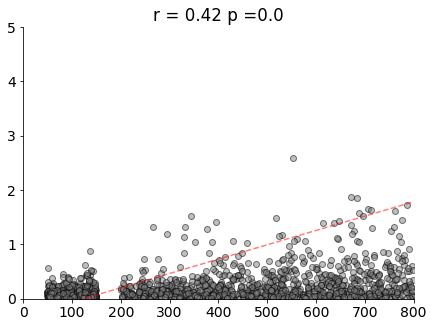

In [5]:
null_df_byGroup=get_null_distribution(sc_df_dict_null,sc_df_all,beh_var_lbl='paramsDiff_S',\
                               neu_feat='S0reg')

x = null_df_byGroup['change_in_n'].to_numpy()
y = np.absolute(null_df_byGroup['rel_imp_score'].to_numpy()-1)

C.plot_scatter(x,y,use_spearman=True);
ax=plt.gca()
ax.set_ylim(0,5)

#### Model parameters

0.5691699604743083
0.5731225296442688


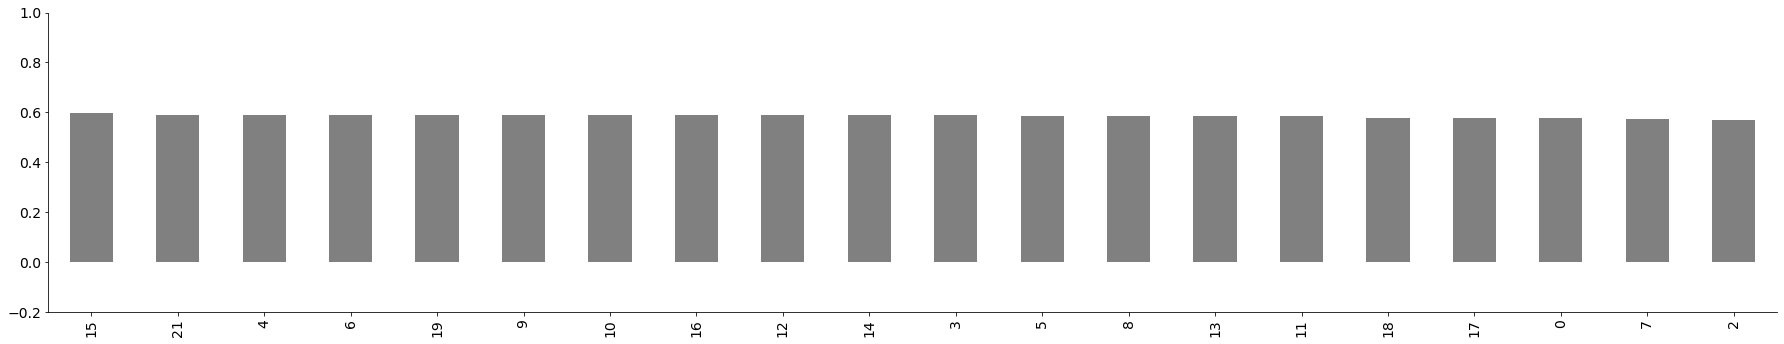

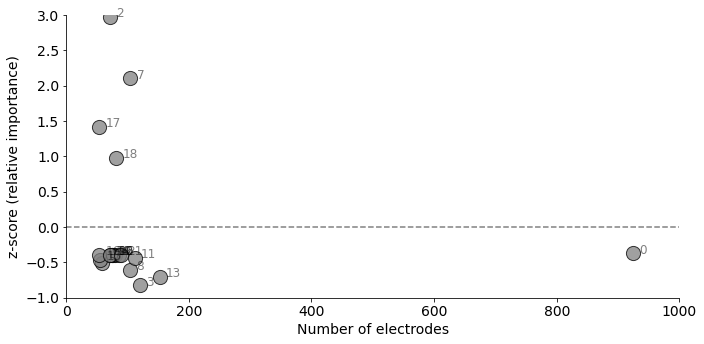

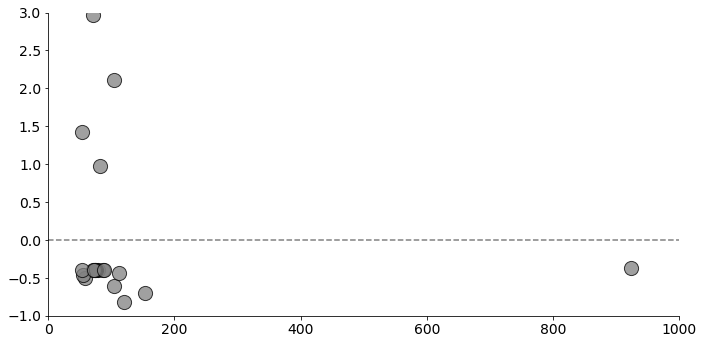

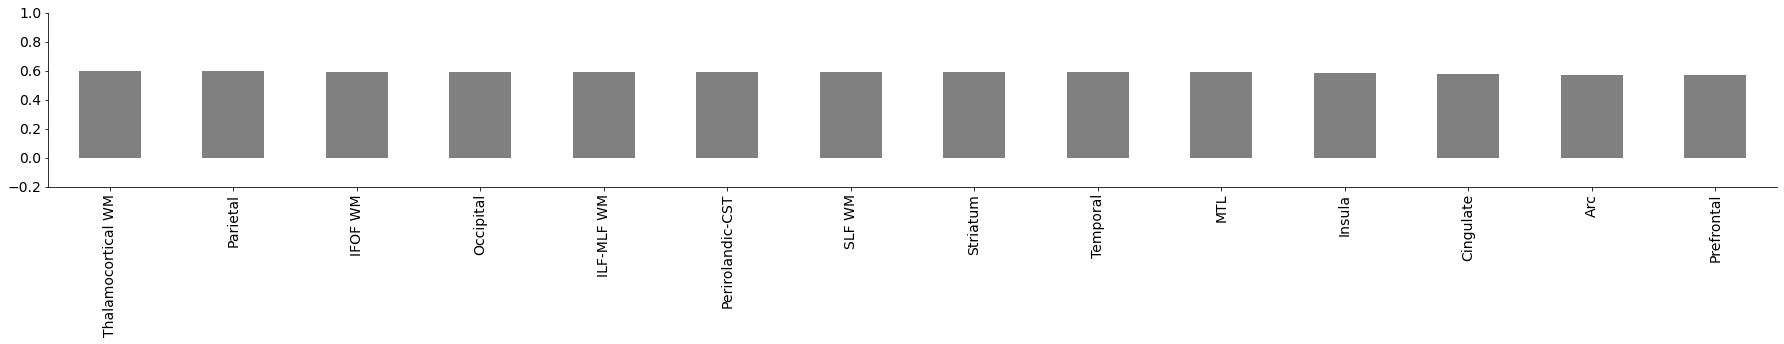

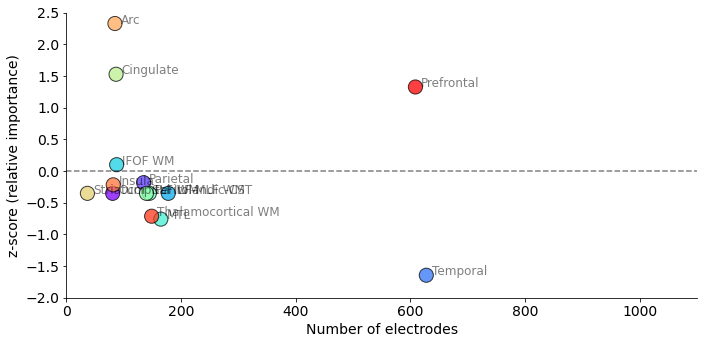

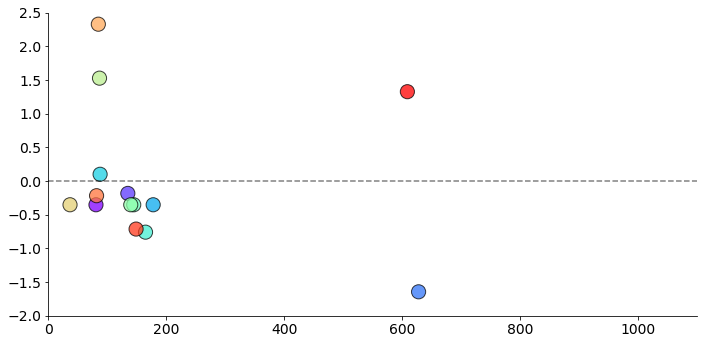

In [15]:
corr_df_byGroup_clus_SR = plot_wrapper(sc_df_dict_clus,sc_df_all,beh_var_lbl='paramsDiff_B',neu_feat='SR_headingCorrectMean',\
                               grouping_lbl='cluster',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5',\
                               scat_xl = None)#,scat_yl = (0.9,1.15)
corr_df_byGroup_anat_SR = plot_wrapper(sc_df_dict_anat,sc_df_all,beh_var_lbl='paramsDiff_B',neu_feat='SR_headingCorrectMean',\
                               grouping_lbl='region',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color=anat_col_array,\
                               scat_xl = (0,1100))#,scat_yl = (0.9,1.15)
#corr_df_byGroup = plot_wrapper(sc_df_dict_func,sc_df_all,beh_var_lbl='rtDiff_std',neu_feat='S0reg',grouping_lbl='function')

In [14]:
corr_df_byGroup_anat_SR['corr_prct_change']

Occipital            -0.000000
Parietal              0.668896
Temporal             -0.501672
ILF-MLF WM           -0.000000
IFOF WM               0.334448
MTL                  -0.501672
Perirolandic-CST     -0.000000
SLF WM               -0.000000
Cingulate            -2.341137
Striatum             -0.000000
Arc                  -3.010033
Insula               -0.836120
Thalamocortical WM    1.170569
Prefrontal           -3.010033
Name: corr_prct_change, dtype: float64

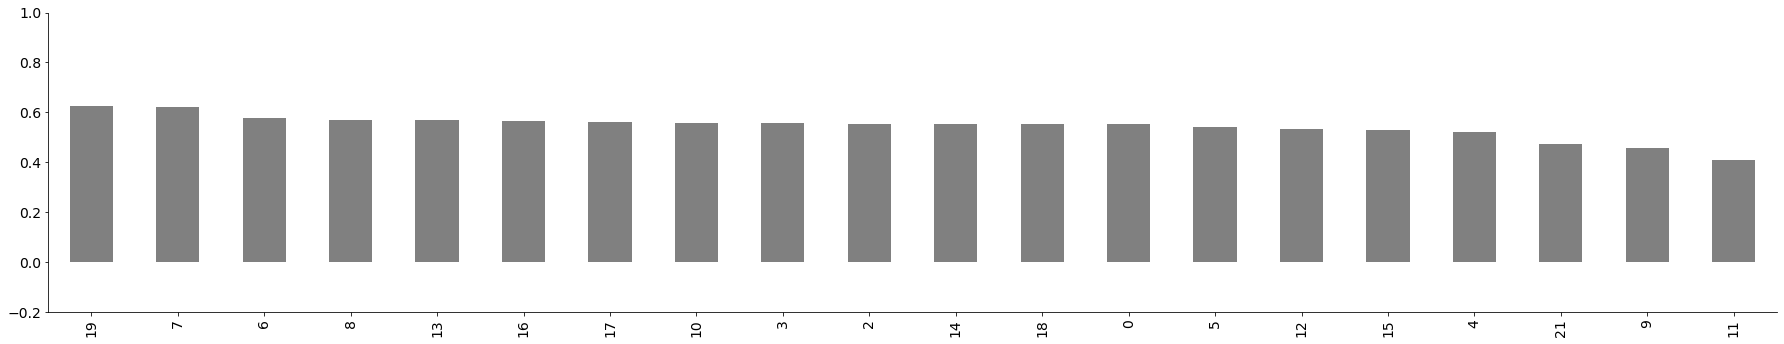

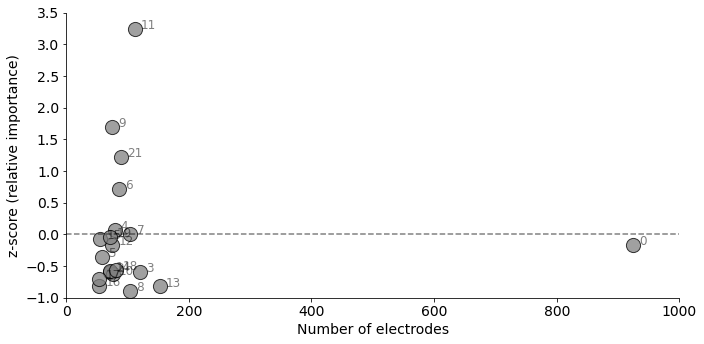

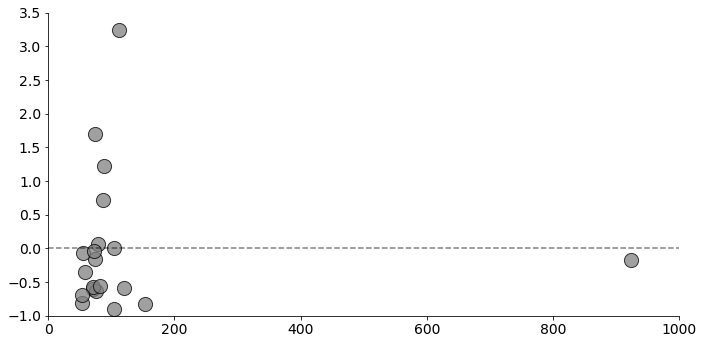

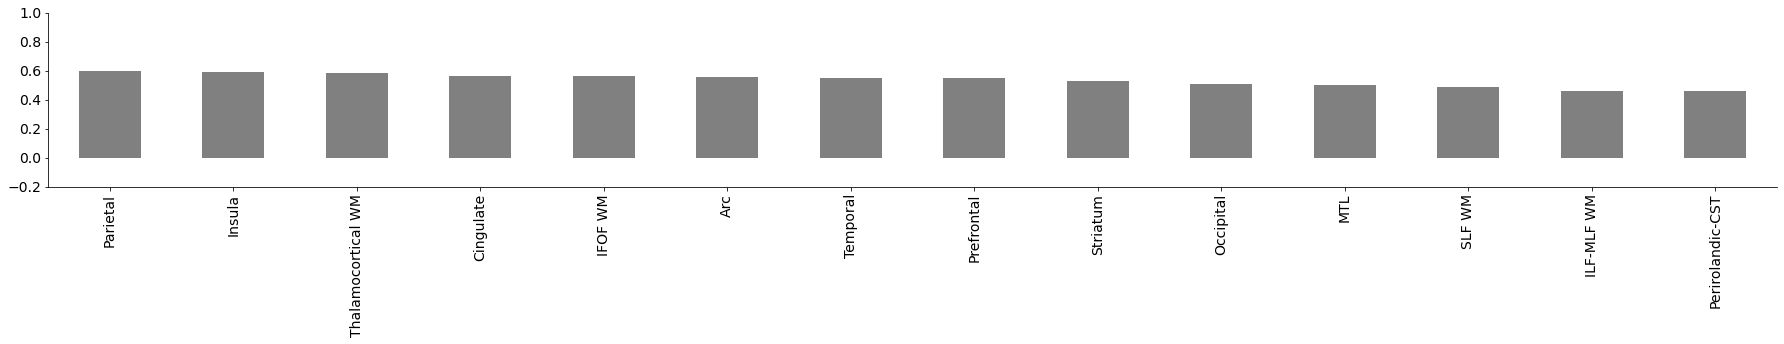

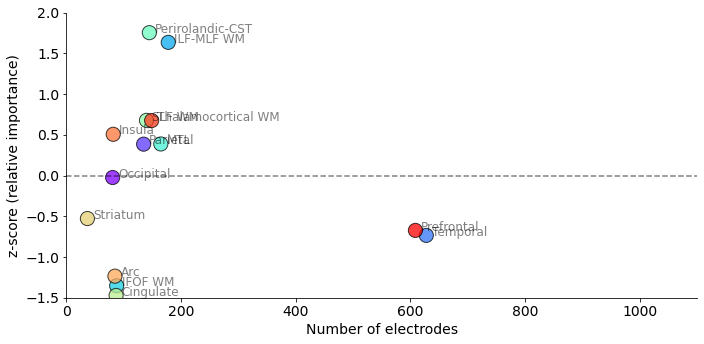

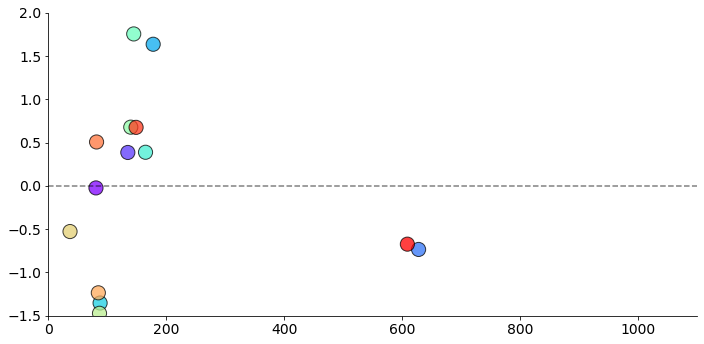

In [6]:
corr_df_byGroup_clus_S0 = plot_wrapper(sc_df_dict_clus,sc_df_all,beh_var_lbl='paramsDiff_S',neu_feat='S0reg',\
                               grouping_lbl='cluster',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5',\
                              )#scat_xl = (0,1100),scat_yl = (0.8,2.75)
corr_df_byGroup_anat_S0 = plot_wrapper(sc_df_dict_anat,sc_df_all,beh_var_lbl='paramsDiff_S',neu_feat='S0reg',\
                               grouping_lbl='region',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,\
                               color=anat_col_array,\
                              scat_xl = (0,1100))#,scat_yl = (0.8,2.75)

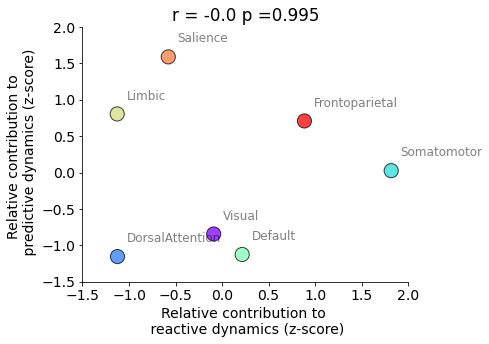

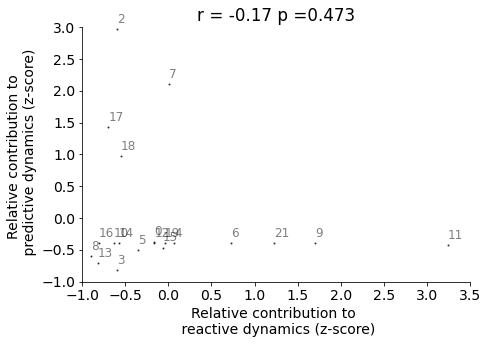

In [8]:
# Joint distribution anatomy
C.plot_scatter(corr_df_byGroup_anat_S0['rel_imp_score_adj_z'],\
               corr_df_byGroup_anat_SR['rel_imp_score_adj_z'],\
               s=200,color=anat_col_array,\
                   plotLine=True,text_lbls = corr_df_byGroup_anat_SR.index,text_offset_x=.1,\
                   text_offset_y =0.2,alpha=0.75)
ax = plt.gca()
ax.set_xlabel('Relative contribution to \n reactive dynamics (z-score)')
ax.set_ylabel('Relative contribution to \n predictive dynamics (z-score)')
#ax.set_xlim(-2.5,3.5)
#ax.set_ylim(-2.5,3.5)
save_fig('anat_joint-'+atlas+'-pairwise-'+str(include_pairwise_comparisons))



C.plot_scatter(corr_df_byGroup_clus_S0['rel_imp_score_adj_z'],\
               corr_df_byGroup_clus_SR['rel_imp_score_adj_z'],\
               s=1,color='0.5',\
                   plotLine=True,text_lbls = corr_df_byGroup_clus_SR.index,text_offset_x=0,\
                   text_offset_y =0.1,alpha=0.75,figsize=(7,5))
ax = plt.gca()
ax.set_xlabel('Relative contribution to \n reactive dynamics (z-score)')
ax.set_ylabel('Relative contribution to \n predictive dynamics (z-score)')
#ax.set_xlim(-1,4)
#ax.set_ylim(-1,4)

save_fig('clus_joint-'+atlas+'-pairwise-'+str(include_pairwise_comparisons))


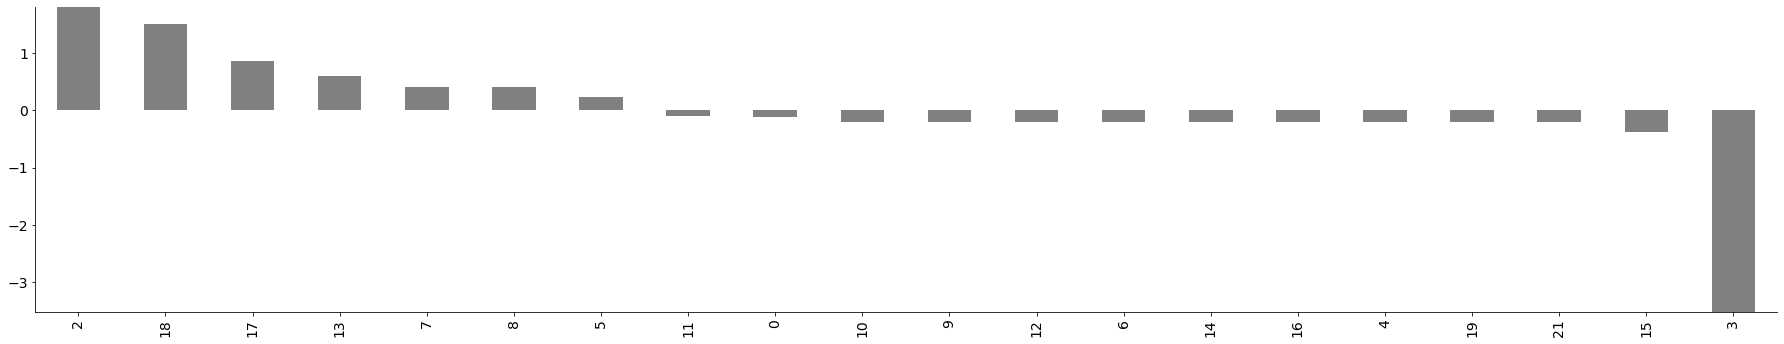

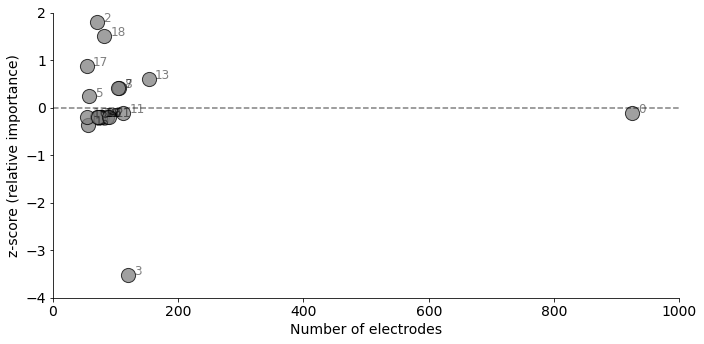

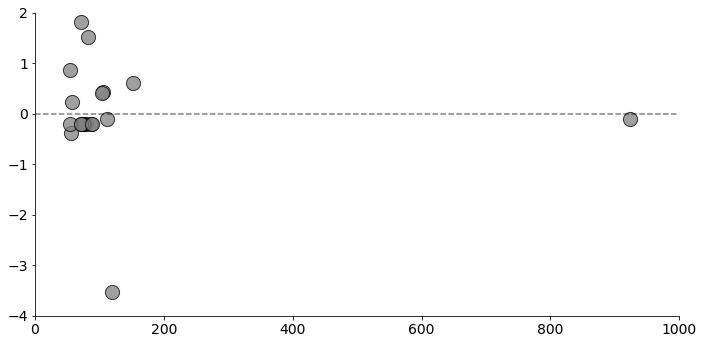

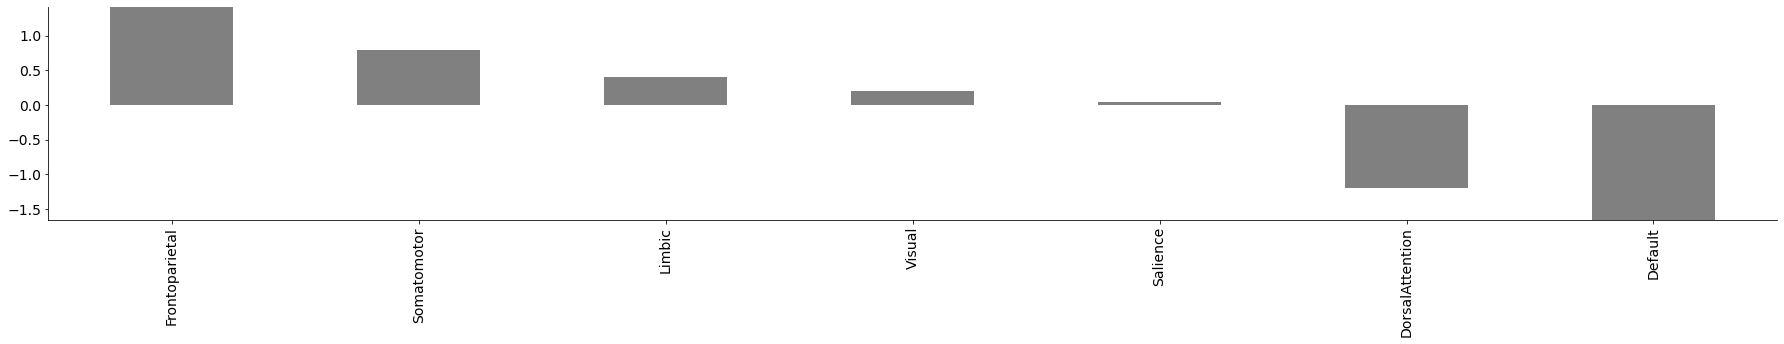

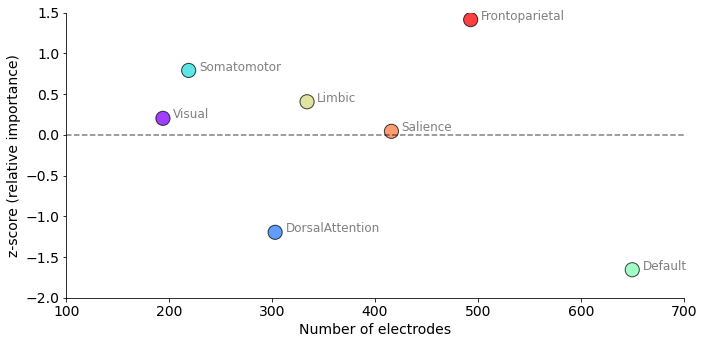

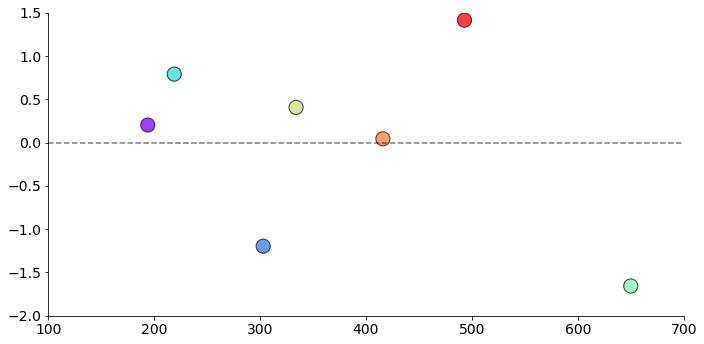

In [22]:
corr_df_byGroup = plot_wrapper(sc_df_dict_clus,sc_df_all,beh_var_lbl='paramsDiff_S',neu_feat='SR_headingCorrectMean',\
                               grouping_lbl='cluster',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5',\
                              )#scat_xl = (0,1100),scat_yl = (0.95,1.12)
corr_df_byGroup = plot_wrapper(sc_df_dict_anat,sc_df_all,beh_var_lbl='paramsDiff_S',neu_feat='SR_headingCorrectMean',\
                               grouping_lbl='region',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color=anat_col_array,\
                              )#scat_xl = (0,1100),scat_yl = (0.95,1.12)

#### Behavioral measures (model-free)

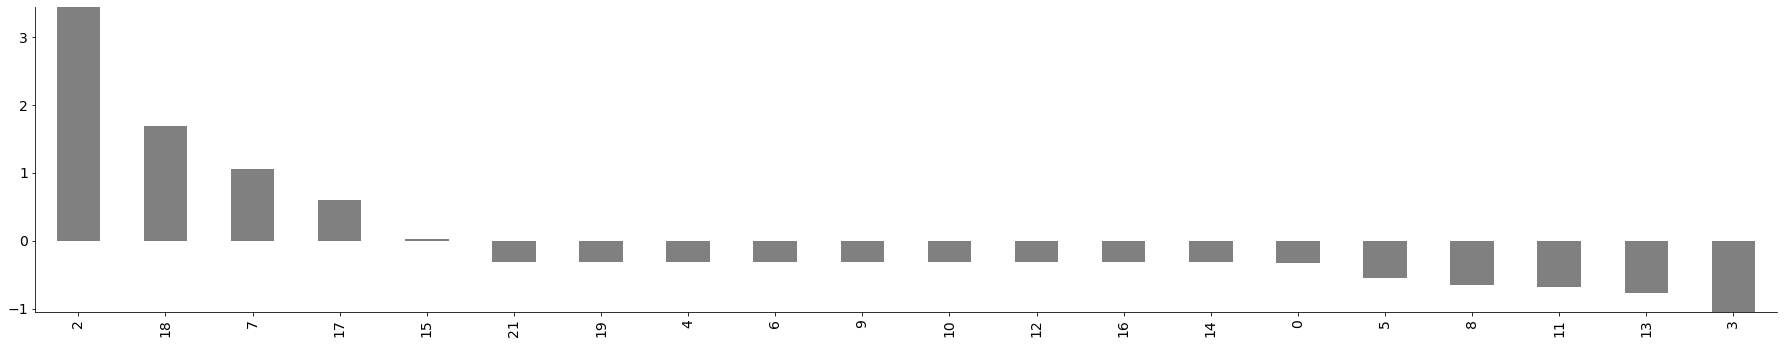

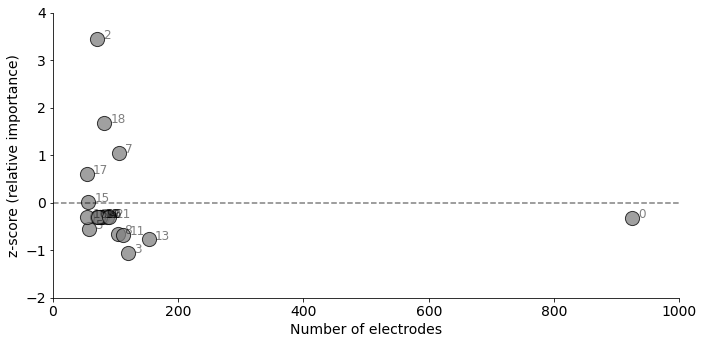

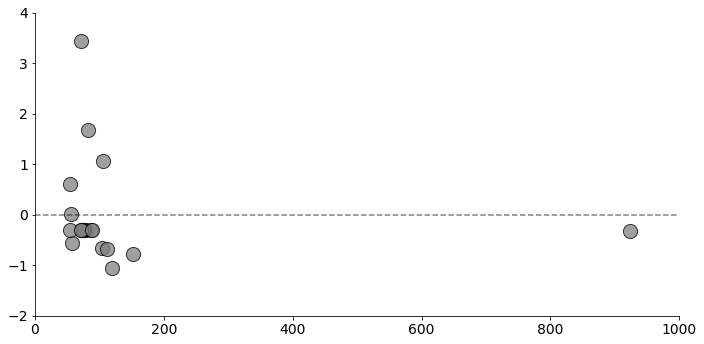

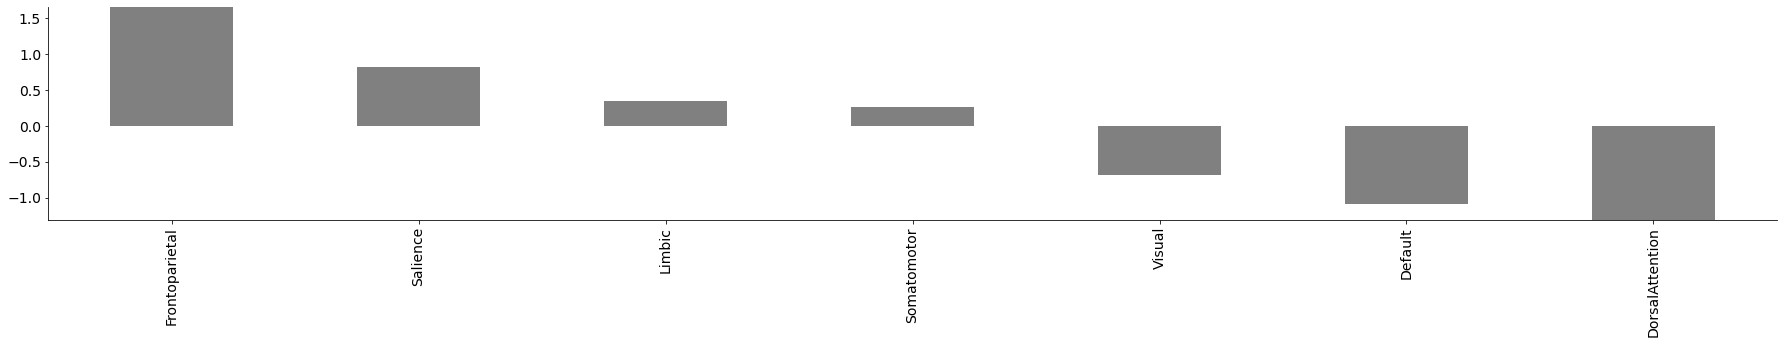

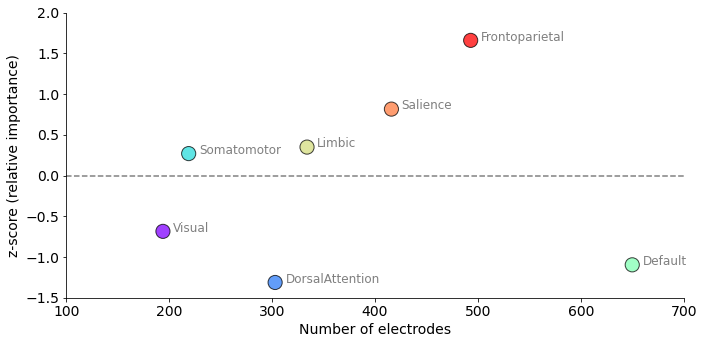

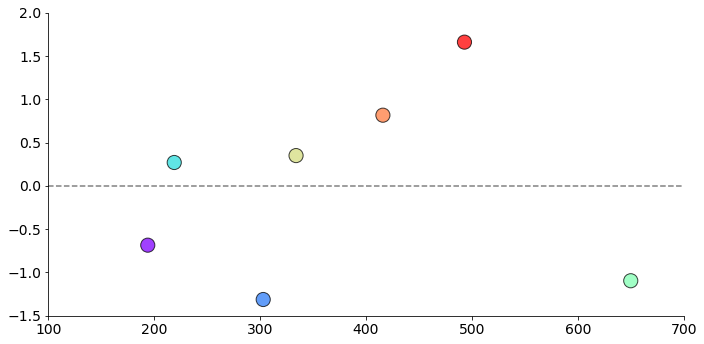

In [23]:
   
corr_df_byGroup = plot_wrapper(sc_df_dict_clus,sc_df_all,beh_var_lbl='rtDiff_mean',\
                               neu_feat='SR_headingCorrectMean',grouping_lbl='cluster',
                              \
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5')
#scat_xl = (0,1100),scat_yl = (0.95,1.1)
corr_df_byGroup = plot_wrapper(sc_df_dict_anat,sc_df_all,beh_var_lbl='rtDiff_mean',\
                               neu_feat='SR_headingCorrectMean',grouping_lbl='region',\
                              \
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color=anat_col_array)
#scat_xl = (0,1100),scat_yl = (0.95,1.1),
#corr_df_byGroup = plot_wrapper(sc_df_dict_func,sc_df_all,beh_var_lbl='rtDiff_mean',neu_feat='SR_headingCorrectMean',grouping_lbl='function')


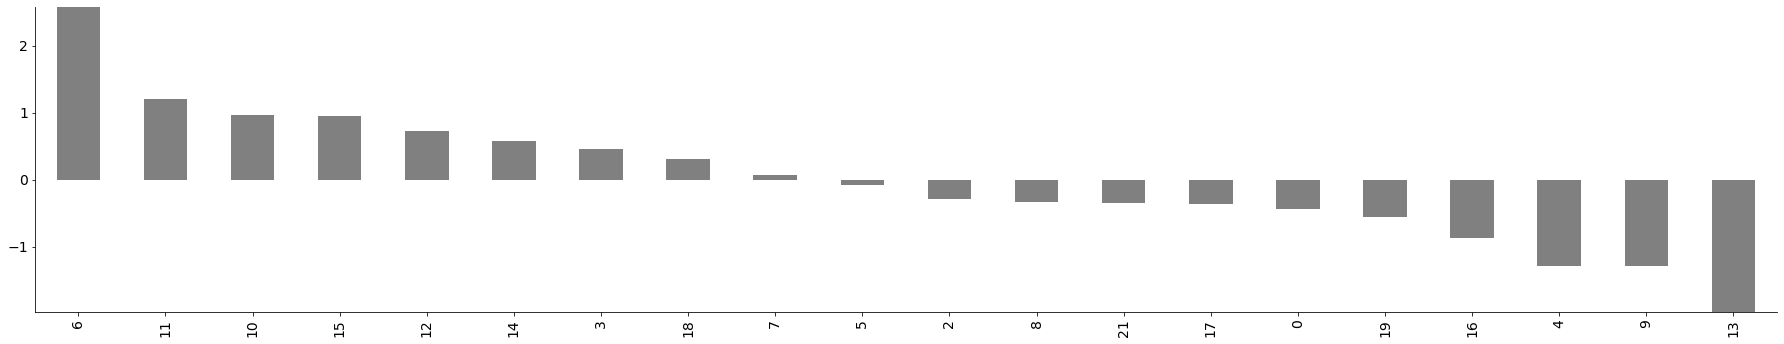

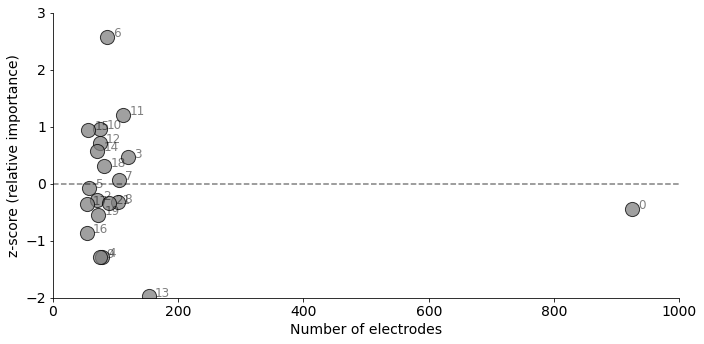

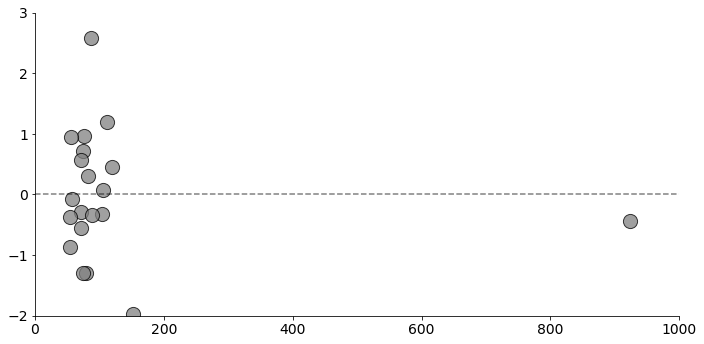

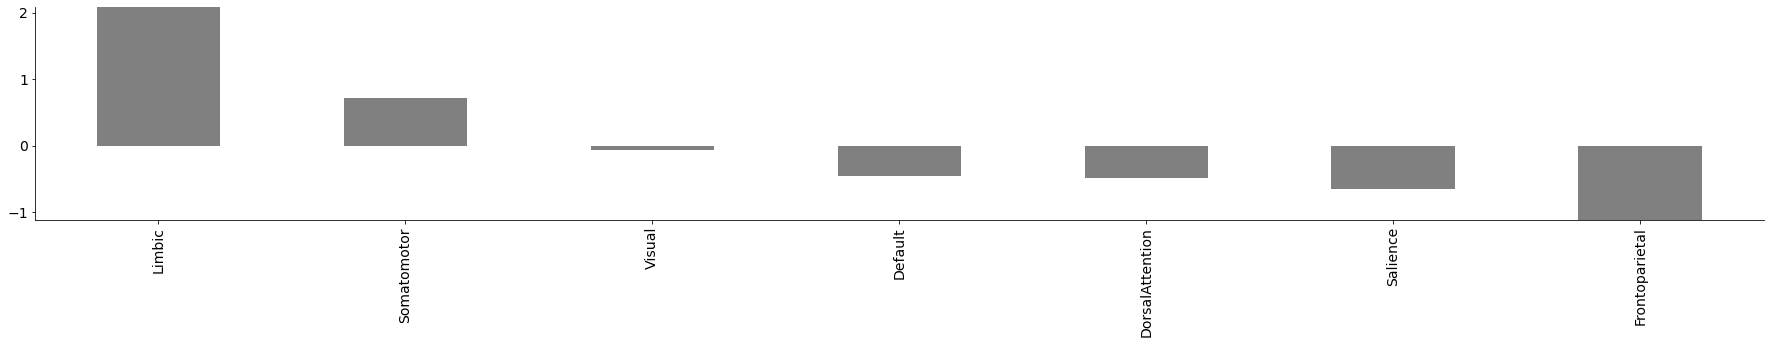

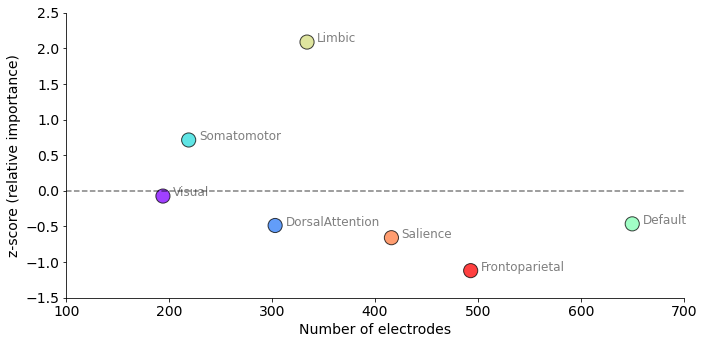

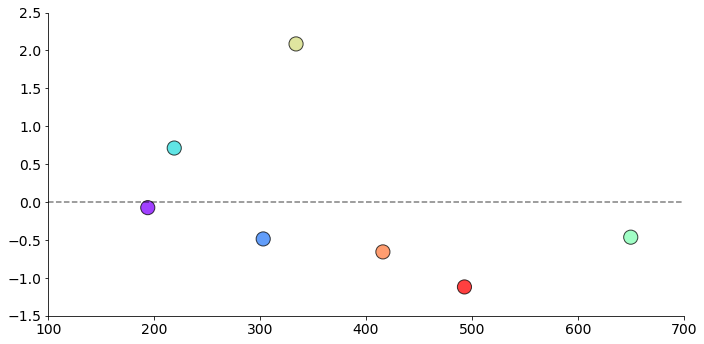

In [24]:
corr_df_byGroup = plot_wrapper(sc_df_dict_clus,sc_df_all,\
                               beh_var_lbl='error_diff',neu_feat='SR_distMean',\
                               grouping_lbl='cluster',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5',\
                             )# scat_xl = (0,1100),scat_yl = (0.85,1.6)
corr_df_byGroup = plot_wrapper(sc_df_dict_anat,sc_df_all,\
                               beh_var_lbl='error_diff',neu_feat='SR_distMean',\
                               grouping_lbl='region',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color=anat_col_array,\
                              )#scat_xl = (0,1100),scat_yl = (0.85,1.6)
#corr_df_byGroup = plot_wrapper(sc_df_dict_func,sc_df_all,beh_var_lbl='error_diff',neu_feat='SR_distMean',grouping_lbl='function')


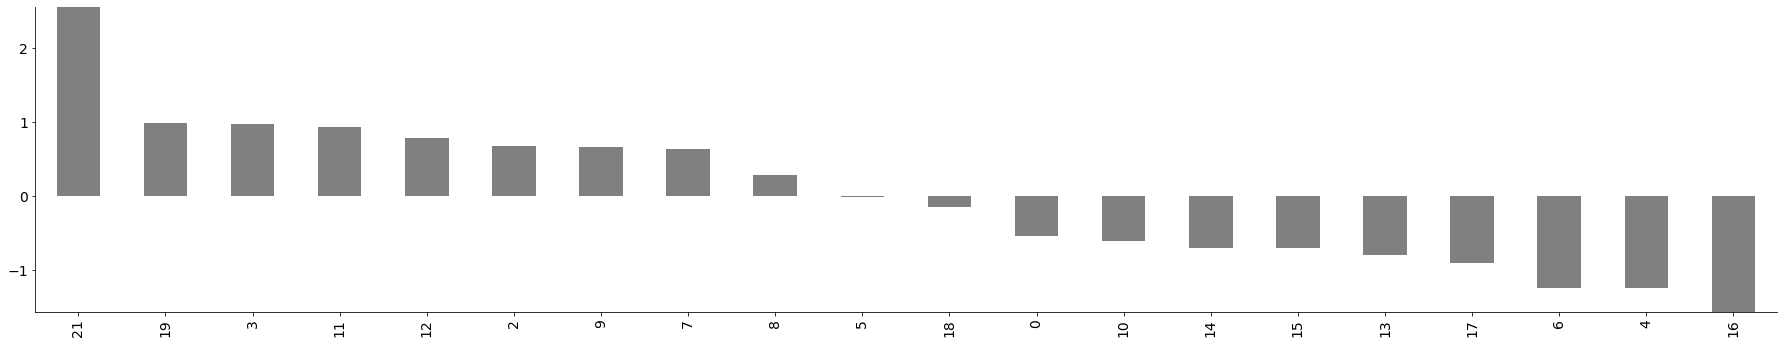

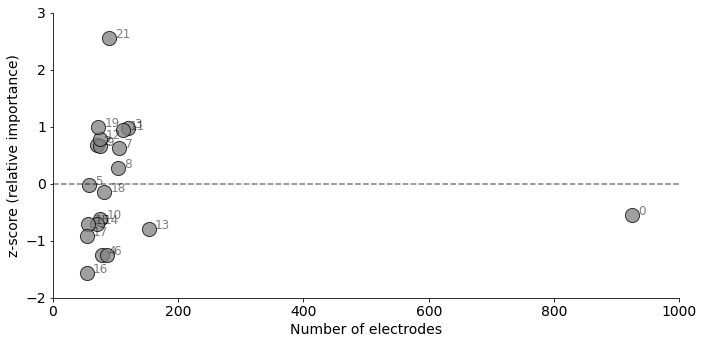

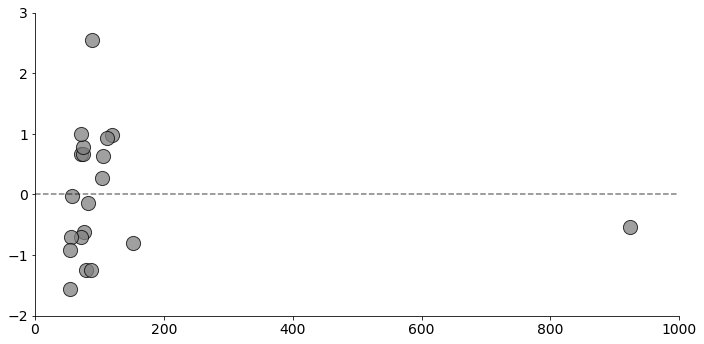

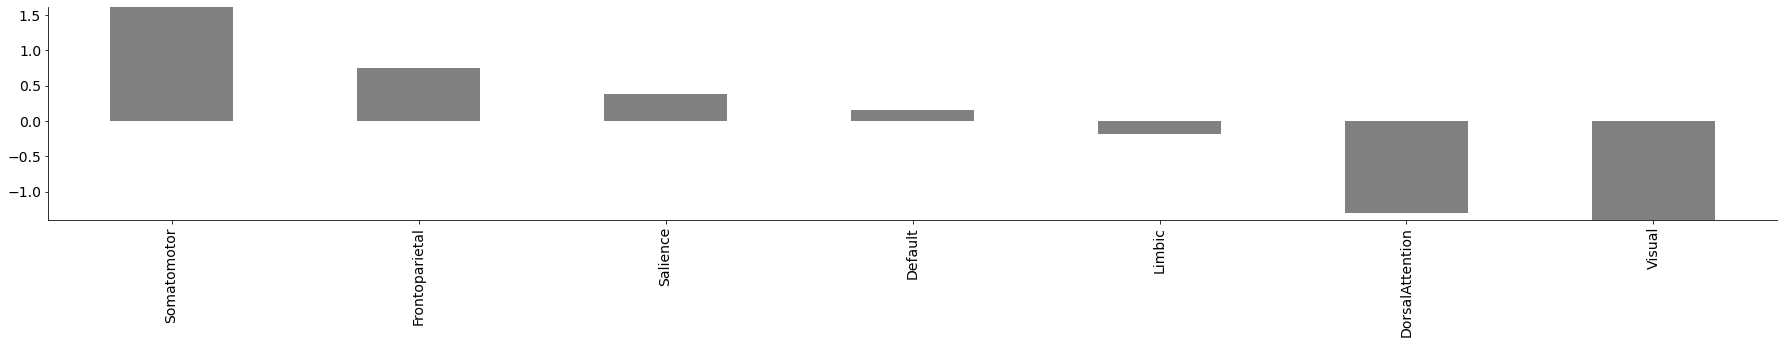

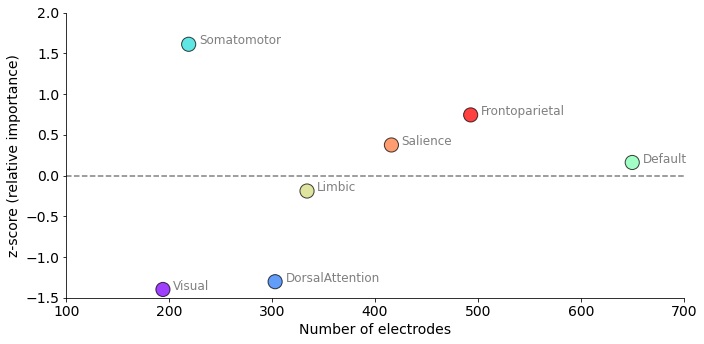

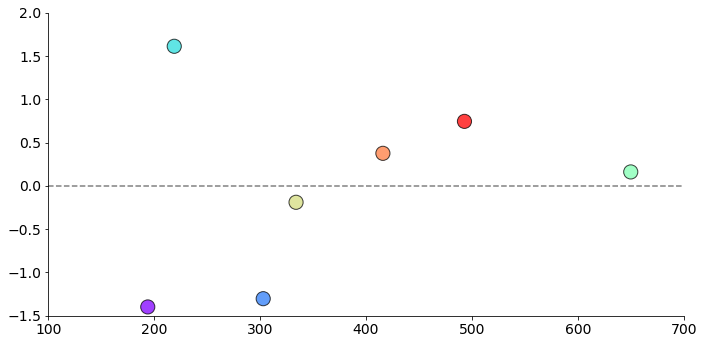

In [25]:
corr_df_byGroup = plot_wrapper(sc_df_dict_clus,sc_df_all,beh_var_lbl='rtDiff_std',neu_feat='S0reg',\
                               grouping_lbl='cluster',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color='0.5',\
                              )#scat_xl = (0,1100)
corr_df_byGroup = plot_wrapper(sc_df_dict_anat,sc_df_all,beh_var_lbl='rtDiff_std',neu_feat='S0reg',\
                               grouping_lbl='region',\
                               plot_null_ci = True, sc_df_dict_null =sc_df_dict_null,color=anat_col_array,\
                              )#scat_xl = (0,1100)
#corr_df_byGroup = plot_wrapper(sc_df_dict_func,sc_df_all,beh_var_lbl='rtDiff_std',neu_feat='S0reg',grouping_lbl='function')

#### OLD

In [ ]:

# def get_xSubj_corr(C,sc_df,beh_var_lbl,neu_feat_list,plot_it = False,s_idx=None,remove_zeros=False,use_zstats=False,resid_str = ''):
#     # This subfunction will compute a dictionary for a sc_df (includes correlation value, number of total electrodes)

#     # parse subj idx (to perform analysis only for a subgroup o fsubjects)
#     if s_idx is None:
#         s_idx = np.ones(len(sc_df)).astype('bool')
    
#     # containers
#     corr_dict = {}
#     # total number of electrodes in this sc_df
#     corr_dict['n_obs'] = np.sum(sc_df['n_obs'].to_numpy())
#     for n in neu_feat_list:
#         #define neural label
#         if use_zstats==False:
#             n_lbl = 'popByDelay'+resid_str+'_'+n+'_diff'
#             ylbl = 'diff score'
#         elif use_zstats==True:
#             n_lbl = 'popByDelay'+resid_str+'_'+n+'_zstatnp'
#             ylbl = 'z stat (non param)'
        
#         # collect r vlas and p-vals
#         r_value,p_value = stats.spearmanr(sc_df[beh_var_lbl][s_idx],sc_df[n_lbl][s_idx])
        
#         # append to dict
#         corr_dict[n] =r_value
#         #corr_dict['pval_'+beh_var_lbl+'-'+n] =p_value
    
        
#     # [ ] plot bar plot indicating spearman r for each feature
#     if plot_it == True:
#         f = plt.figure()
#         ax = plt.subplot(111)
#         #print(rvals)
#         ax.bar(np.arange(0,len(corr_dict)),list(corr_dict.values()),color = '0.5',edgecolor='k')
#         ax.set_xticks(np.arange(0,len(neu_feat_list)))
#         ax.set_xticklabels(neu_feat_list,rotation=90)
        
#     return corr_dict



# # get corr df for RT mean (all subj)
# s_idx = None
# grp_lbl_list = list(sc_df_dict.keys())

# corr_dict_list = []
# for grp_lbl in grp_lbl_list:
#     corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='rtDiff_mean',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
#     corr_dict_list.append(corr_dict)

# # convert to dataframe
# corr_df_biasByClus = pd.DataFrame(corr_dict_list,index = grp_lbl_list)

# # plot a neural feature
# n = 'SR_headingCorrectMean'
# f = plt.figure(figsize=(7,5))
# ax = plt.subplot(111)
# #corr_df_biasByClus.sort_values(by=n)[n]
# corr_df_biasByClus.sort_values(by=n,ascending=False)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
# plt.gca().set_ylim((-0.78,-0.76))
# save_fig('rtDiffMean_SR_headingCorrect_imporantClusters')

In [ ]:
# ### get corr df for RT std (all subj)
# s_idx = None
# grp_lbl_list = list(sc_df_dict.keys())

# corr_dict_list = []
# for grp_lbl in grp_lbl_list:
#     corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='rtDiff_std',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
#     corr_dict_list.append(corr_dict)

# # convert to dataframe
# corr_df_biasByClus = pd.DataFrame(corr_dict_list,index = grp_lbl_list)

# # plot a neural feature
# n = 'S0reg'
# f = plt.figure(figsize=(7,5))
# ax = plt.subplot(111)
# #corr_df_biasByClus.sort_values(by=n)[n]
# corr_df_biasByClus.sort_values(by=n,ascending=True)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
# plt.gca().set_ylim((0.3,0.6))
# save_fig('rtDiff_std_S0reg_imporantClusters')


# # plot a neural feature
# n = 'S0var'
# f = plt.figure(figsize=(7,5))
# ax = plt.subplot(111)
# #corr_df_biasByClus.sort_values(by=n)[n]
# corr_df_biasByClus.sort_values(by=n,ascending=False)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
# plt.gca().set_ylim((-0.3,-0.5))
# save_fig('rtDiff_std_S0var_imporantClusters')

In [ ]:
# # get corr df for anticipatory false alarm rate (all subj)
# s_idx = None
# grp_lbl_list = list(sc_df_dict.keys())

# corr_dict_list = []
# for grp_lbl in grp_lbl_list:
#     corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='error_diff',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
#     corr_dict_list.append(corr_dict)

# # convert to dataframe
# corr_df_biasByClus = pd.DataFrame(corr_dict_list,index = grp_lbl_list)

# # plot a neural feature
# n = 'SR_distMean'
# f = plt.figure(figsize=(7,5))
# ax = plt.subplot(111)
# #corr_df_biasByClus.sort_values(by=n)[n]
# corr_df_biasByClus.sort_values(by=n,ascending=True)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
# plt.gca().set_ylim((0.52,.58))
# save_fig('errorDiff_SR_distMean_imporantClusters')

In [12]:
# get corr df for bias parameter (all subjects)
s_idx = None
grp_lbl_list = list(sc_df_dict.keys())

corr_dict_list = []
for grp_lbl in grp_lbl_list:
    corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='paramsDiff_B',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
    corr_dict_list.append(corr_dict)

# convert to dataframe
corr_df_biasByClus = pd.DataFrame(corr_dict_list,index = grp_lbl_list)

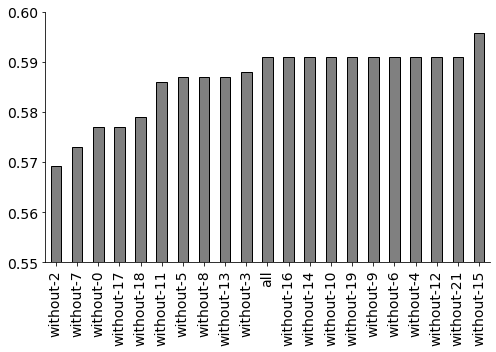

In [12]:
# plot a neural feature
n = 'SR_headingCorrectMean'
f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
corr_df_biasByClus.sort_values(by=n)[n]
corr_df_biasByClus.sort_values(by=n)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
plt.gca().set_ylim((0.55,0.6))
save_fig('antBias_SR_headingCorrect_imporantClusters')

In [16]:
# get corr df for bias parameter (excluding high bias subjects)
s_idx = sc_df_dict['all'].eval('paramsDiff_B<=0.1')
grp_lbl_list = list(sc_df_dict.keys())

corr_dict_list = []
for grp_lbl in grp_lbl_list:
    corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='paramsDiff_B',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
    corr_dict_list.append(corr_dict)

# convert to dataframe
corr_df_biasByClus_lowBiasSubj = pd.DataFrame(corr_dict_list,index = grp_lbl_list)


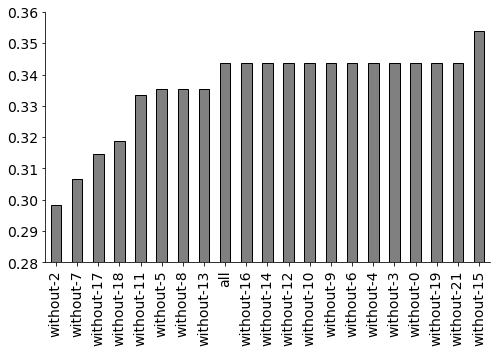

In [17]:
# plot a neural feature
n = 'SR_headingCorrectMean'
f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
corr_df_biasByClus_lowBiasSubj.sort_values(by=n)[n]
corr_df_biasByClus_lowBiasSubj.sort_values(by=n)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
plt.gca().set_ylim((0.28,0.36))
save_fig('antBias_SR_headingCorrect_lowBiasSubj_imporantClusters')

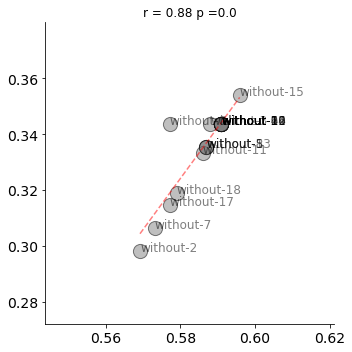

In [18]:
# feature importance correlation (all subj vs. low bias subj)
n = 'SR_headingCorrectMean'
C.plot_scatter(corr_df_biasByClus[n].to_numpy(),corr_df_biasByClus_lowBiasSubj[n].to_numpy(),s=200,\
               text_lbls = np.array(list(sc_df_dict.keys())), use_spearman=True,figsize=(5,5));
plt.gca().axis('tight')
save_fig('antBias_SR_headingCorrect_corr')

In [19]:
# get corr df for sensitivity parameter (excluding high bias subjects)
s_idx = sc_df_dict['all'].eval('paramsDiff_B<=0.1')
grp_lbl_list = list(sc_df_dict.keys())

corr_dict_list = []
for grp_lbl in grp_lbl_list:
    corr_dict = get_xSubj_corr(C,sc_df_dict[grp_lbl],beh_var_lbl='paramsDiff_S',use_zstats=False,neu_feat_list=neu_feat_list,plot_it = False,s_idx=s_idx)
    corr_dict_list.append(corr_dict)

# convert to dataframe
corr_df_sensByClus_lowBiasSubj = pd.DataFrame(corr_dict_list,index = grp_lbl_list)

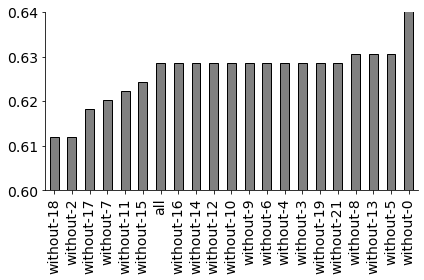

In [21]:
# plot a neural feature
n = 'SR_headingCorrectMean'
f = plt.figure()
ax = plt.subplot(111)
corr_df_sensByClus_lowBiasSubj.sort_values(by=n)[n]
corr_df_sensByClus_lowBiasSubj.sort_values(by=n)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
plt.gca().set_ylim((0.6,.64))
save_fig('sensitivity_SR_headingCorrect_lowBiasSubj_imporantClusters')

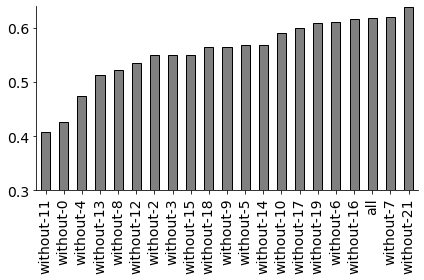

In [23]:
# plot a neural feature
n = 'S0reg'
f = plt.figure()
ax = plt.subplot(111)
corr_df_sensByClus_lowBiasSubj.sort_values(by=n)[n]
corr_df_sensByClus_lowBiasSubj.sort_values(by=n)[n].plot(kind='bar',facecolor='0.5',edgecolor='k')
plt.gca().set_ylim((0.3,.64))
save_fig('sensitivity_S0reg_lowBiasSubj_imporantClusters')